In [1273]:
!pip install networkx geopy

In [45]:
import pandas as pd
import numpy as np
import networkx as nx
from geopy.distance import geodesic
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree


In [3]:
df = pd.read_csv('stage3.csv',sep=',')

In [4]:
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [5]:
df[df['participant_age'].isna()][['gun_stolen','gun_type','participant_age','participant_age_group']]

,gun_stolen,gun_type,participant_age,participant_age_group
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,0::Teen 12-17||1::Teen 12-17||2::Teen 12-17||4...
13,0::Unknown,0::Handgun,NaN,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...
24,NaN,NaN,NaN,0::Adult 18+||1::Adult 18+
37,NaN,NaN,NaN,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...
...,...,...,...,...
239656,0::Unknown,0::Unknown,NaN,NaN
239659,0::Unknown,0::Unknown,NaN,0::Adult 18+||1::Adult 18+||2::Adult 18+
239661,0::Unknown,0::Unknown,NaN,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...
239668,0::Unknown,0::Unknown,NaN,NaN


In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df['codmes'] = df['date'].dt.year*100+df['date'].dt.month

In [8]:
df['date'].dt.year.value_counts().sort_index()

date
2013      278
2014    51854
2015    53579
2016    58763
2017    61401
2018    13802
Name: count, dtype: int64

In [9]:
df['codmes'].value_counts().sort_index()

codmes
201301      15
201302      12
201303      19
201304      17
201305      27
          ... 
201711    4802
201712    4622
201801    4926
201802    4124
201803    4752
Name: count, Length: 63, dtype: int64

In [10]:
## revision de null

In [11]:
df.isna().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

In [12]:
df.shape

(239677, 30)

In [13]:
df_sin_na = df.dropna(subset=['latitude','longitude'])
print(df_sin_na.shape)

(231754, 30)


In [14]:
df_sin_na = df.dropna(subset=['participant_type'])
print(df_sin_na.shape)

(214814, 30)


In [15]:
df_sin_na.isna().sum() / df_sin_na.shape[0]

incident_id                    0.000000
date                           0.000000
state                          0.000000
city_or_county                 0.000000
address                        0.070936
n_killed                       0.000000
n_injured                      0.000000
incident_url                   0.000000
source_url                     0.002067
incident_url_fields_missing    0.000000
congressional_district         0.049745
gun_stolen                     0.419856
gun_type                       0.419707
incident_characteristics       0.001289
latitude                       0.034453
location_description           0.826380
longitude                      0.034453
n_guns_involved                0.419707
notes                          0.334946
participant_age                0.313923
participant_age_group          0.080330
participant_gender             0.053530
participant_name               0.453369
participant_relationship       0.926569
participant_status             0.012862


In [16]:
### obtener información de las variables participant

In [18]:
df_sin_na['n_age_0_11'] = df_sin_na['participant_age_group'].str.count('Child 0-11')
df_sin_na['n_age_12_17'] = df_sin_na['participant_age_group'].str.count('Teen 12-17')
df_sin_na['n_age_18'] = df_sin_na['participant_age_group'].str.count('Adult 18+')

df_sin_na['n_male'] = df_sin_na['participant_gender'].str.count('Male')
df_sin_na['n_female'] = df_sin_na['participant_gender'].str.count('Female')

df_sin_na['n_arrested'] = df_sin_na['participant_status'].str.count('Arrested')

df_sin_na['n_victim'] = df_sin_na['participant_type'].str.count('Victim')
df_sin_na['n_suspect'] = df_sin_na['participant_type'].str.count('Subject-Suspect')

/tmp/ipykernel_2400/4042728914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_na['n_age_0_11'] = df_sin_na['participant_age_group'].str.count('Child 0-11')
/tmp/ipykernel_2400/4042728914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_na['n_age_12_17'] = df_sin_na['participant_age_group'].str.count('Teen 12-17')
/tmp/ipykernel_2400/4042728914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [404]:
df_sin_na.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district', 'codmes', 'n_age_0_11', 'n_age_12_17',
       'n_age_18', 'n_male', 'n_female', 'n_arrested', 'n_victim',
       'n_suspect'],
      dtype='object')

In [405]:
var_group = ['codmes','longitude','latitude']
var_columns = {
    'incident_id':'max',
    'state':'max',
    'city_or_county':'max',
    'n_killed':'sum',
    'n_injured':'sum',
    'n_age_0_11':'sum',
    'n_age_12_17':'sum',
    'n_age_18':'sum',
    'n_male':'sum',
    'n_female':'sum',
    'n_arrested':'sum',
    'n_victim':'sum',
    'n_suspect':'sum'
}

In [406]:
df_final = df_sin_na.groupby(var_group).agg(var_columns).reset_index()

In [407]:
df_final.head()

,codmes,longitude,latitude,incident_id,state,city_or_county,n_killed,n_injured,n_age_0_11,n_age_12_17,n_age_18,n_male,n_female,n_arrested,n_victim,n_suspect
0,201301,-121.7180,37.9656,479389,California,Brentwood,0,4,0.0,3.0,1.0,5.0,0.0,0.0,4,1
1,201301,-118.3330,33.9090,460726,California,Hawthorne,1,3,0.0,0.0,4.0,1.0,0.0,0.0,4,1
2,201301,-106.7160,34.9791,479363,New Mexico,Albuquerque,5,0,3.0,1.0,2.0,3.0,3.0,1.0,5,1
3,201301,-104.8020,39.6518,478925,Colorado,Aurora,4,0,0.0,0.0,4.0,3.0,1.0,0.0,3,1
4,201301,-95.9768,36.2405,478948,Oklahoma,Tulsa,4,0,0.0,0.0,6.0,2.0,4.0,2.0,4,2


In [480]:
df_final[df_final['incident_id'].isin([996457,994751])][var_group].values

array([[ 2.01711e+05, -1.11984e+02,  4.35183e+01],
       [ 2.01711e+05, -1.11984e+02,  4.35259e+01]])

In [409]:
# df_final['codmes'] = df_final['date'].dt.year*100+df_final['date'].dt.month

In [410]:
df_final.shape

(202515, 16)

In [411]:
df_final['codmes'].value_counts().sort_index()

codmes
201301      15
201302      12
201303      19
201304      17
201305      27
          ... 
201711    4112
201712    4034
201801    4342
201802    3302
201803    3054
Name: count, Length: 63, dtype: int64

In [528]:
df_final.groupby('state').agg({'incident_id':'count'})

,incident_id
state,
Alabama,4979
Alaska,998
Arizona,1993
Arkansas,2445
California,14582
Colorado,2525
Connecticut,2582
Delaware,1496
District of Columbia,2135


### Contruccion del grafo

In [686]:
df_final['codmes'] //100

0         2013
1         2013
2         2013
3         2013
4         2013
          ... 
202510    2018
202511    2018
202512    2018
202513    2018
202514    2018
Name: codmes, Length: 202515, dtype: int32

In [1057]:
df_final_filtered = df_final[df_final['codmes'].isin([201712])]

In [1058]:
coords = df_final_filtered[['latitude', 'longitude']].values
# dates = df_final_filtered['date'].values
incident_ids = df_final_filtered['incident_id'].values

In [1059]:
# Crear un KDTree para búsquedas eficientes
tree = KDTree(np.radians(coords))

# Crear una lista para almacenar las aristas
edges = []


In [1060]:
threshold_distance_km = 20
# threshold_time = timedelta(days=30)

In [1061]:
# Encontrar vecinos cercanos para cada nodo
edges = []

for i, coord in enumerate(coords):
    # Buscar vecinos dentro del umbral de distancia
    indices = tree.query_radius([np.radians(coord)], r=np.radians(threshold_distance_km / 111))[0]
    
    for j in indices:
        if i < j:  # Evitar conexiones duplicadas
#             time_diff = abs(pd.to_timedelta(dates[i] - dates[j]))
#             if time_diff <= threshold_time:
#                 print(incident_ids[j])
            edges.append({
                'source': incident_ids[i],
                'target': incident_ids[j],
                'distance': geodesic(coord, coords[j]).kilometers,
#                     'time_diff': time_diff
                })

In [1062]:
len(edges)

45055

In [1063]:
edges = pd.DataFrame(edges)
edges.head()

,source,target,distance
0,1003301,1007928,16.949926
1,1003301,1018726,13.177866
2,1003301,1013404,11.895601
3,1007928,1018726,4.218064
4,1007928,1013404,15.170175


In [1064]:
edges['distance'].describe()

count    45055.000000
mean         8.598730
std          4.794492
min          0.008301
25%          4.659557
50%          8.174528
75%         12.294583
max         19.970329
Name: distance, dtype: float64

In [1143]:
G = nx.Graph()

In [1144]:
for index, row in df_final_filtered.iterrows():
    G.add_node(row['incident_id'], 
               datetime=row['codmes'], 
               lon=row['longitude'], 
               lat=row['latitude'],
               state=row['state'],
               n_killed=row['n_killed'],
               n_injured=row['n_injured'],
               n_age_0_11=row['n_age_0_11'],
               n_age_12_17=row['n_age_12_17'],
               n_age_18=row['n_age_18'],
               n_male=row['n_male'],
               n_female=row['n_female'],
               n_arrested=row['n_arrested'],
               n_victim=row['n_victim'], 
               n_suspect=row['n_suspect']
              )

In [1145]:
len(G.nodes())

4034

In [1146]:
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'])

In [1147]:
len(G.edges())

45055

In [1148]:
# nx.write_graphml(G, "graph_final.graphml")

In [1149]:
nx.write_gexf(G, 'graph_final.gexf')

In [1150]:
import matplotlib.pyplot as plt

In [1151]:
from collections import Counter

# Obtener todos los valores del atributo 'ciudad'
ciudades = [data.get('state') for node, data in G.nodes(data=True)]

# Contar la cantidad de nodos por cada ciudad
conteo_ciudades = Counter(ciudades)

print("Cantidad de nodos por ciudad:")
for ciudad, cantidad in conteo_ciudades.items():
    print(f"{ciudad}: {cantidad}")

Cantidad de nodos por ciudad:
Alaska: 31
Hawaii: 8
Washington: 89
Oregon: 41
California: 312
Nevada: 33
Idaho: 17
Montana: 11
Arizona: 49
Utah: 14
Wyoming: 3
Colorado: 51
New Mexico: 24
Texas: 178
South Dakota: 8
North Dakota: 4
Kansas: 38
Nebraska: 25
Oklahoma: 71
Minnesota: 35
Iowa: 30
Missouri: 130
Arkansas: 54
Louisiana: 118
Wisconsin: 55
Mississippi: 88
Illinois: 287
Tennessee: 124
Kentucky: 65
Alabama: 98
Indiana: 95
Florida: 265
Michigan: 63
Georgia: 109
Ohio: 200
North Carolina: 143
Virginia: 104
South Carolina: 109
West Virginia: 30
Pennsylvania: 190
New York: 137
Maryland: 138
District of Columbia: 44
Delaware: 26
New Jersey: 81
Connecticut: 57
Massachusetts: 119
New Hampshire: 12
Rhode Island: 4
Maine: 17


In [1227]:
nodes_to_include = [node for node, data in G.nodes(data=True) if data.get('state')=='Nebraska']

In [1228]:
H = G.subgraph(nodes_to_include).copy()

In [1229]:
pos = {node: (H.nodes[node]['lon'], H.nodes[node]['lat']) for node in H.nodes}

In [1230]:
len(H.nodes())

25

In [1231]:
len(H.edges())

120

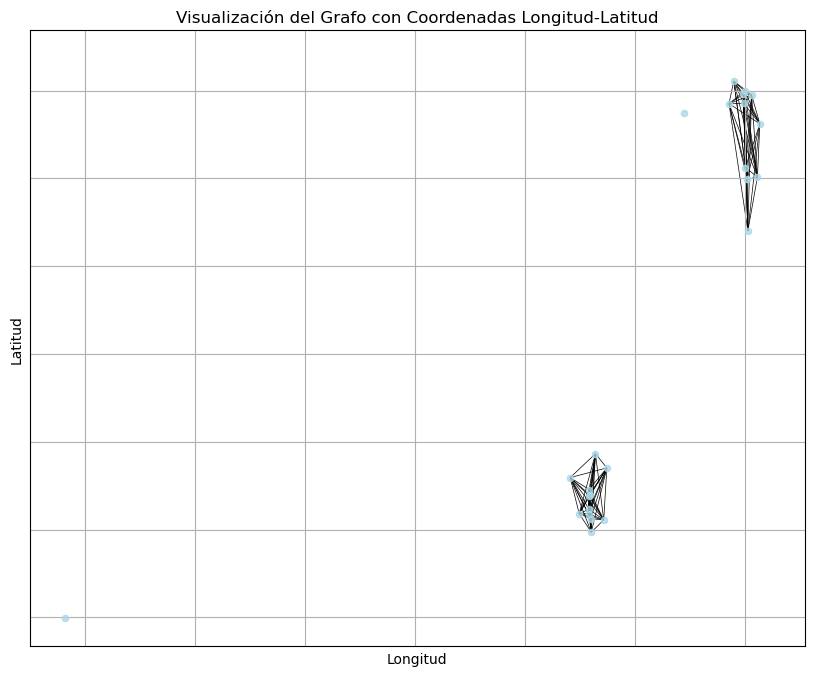

In [1232]:
plt.figure(figsize=(10, 8))

# Dibujar nodos
nx.draw_networkx_nodes(H, pos, node_size=20, node_color='lightblue', alpha=0.8)

# Dibujar aristas
nx.draw_networkx_edges(H, pos, width=0.5)

# Mostrar el gráfico
plt.title('Visualización del Grafo con Coordenadas Longitud-Latitud')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()

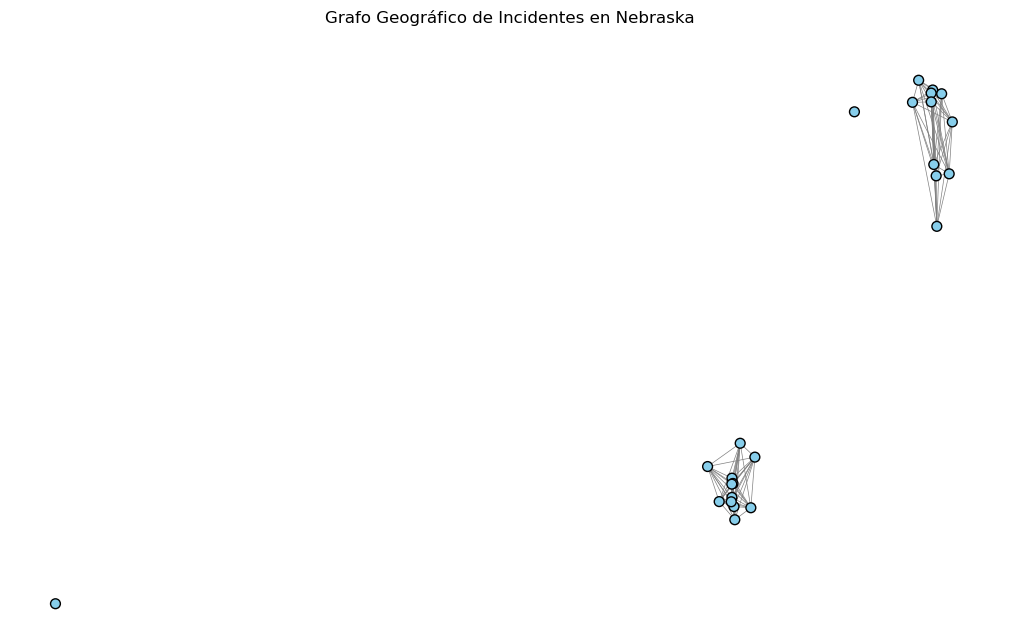

In [1234]:
# Dibujar el grafo en el espacio cartesiano basado en latitud y longitud
pos = {node: (H.nodes[node]['lon'], H.nodes[node]['lat']) for node in H.nodes}
plt.figure(figsize=(10, 6))

# Dibujar los nodos y aristas en función de las coordenadas geográficas
nx.draw(H, pos, with_labels=False,
        node_color=['skyblue' for n in H.nodes()],
        node_size=[50 for n in H.nodes()] ,
        font_size=8, font_weight='bold', edge_color='gray', width=0.5, edgecolors ='black')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title("Grafo Geográfico de Incidentes en Nebraska")
plt.show()

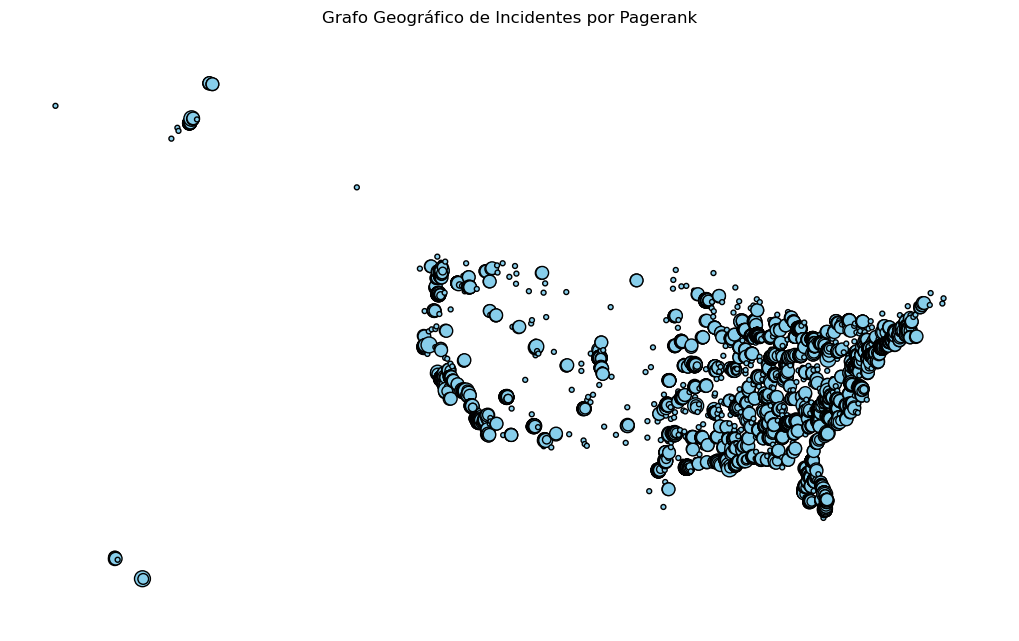

In [1264]:
pagerank = nx.pagerank(G, alpha=0.85)  # alpha es el factor de amortiguación

# Mostrar el PageRank de cada nodo
# print("PageRank de los nodos:")
# for node, rank in pagerank.items():
#     print(f"Nodo {node}: {rank:.4f}")

# Dibujar el grafo con el tamaño de los nodos basado en el PageRank
# pos = {node: (G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes}
node_size = [v * 300000 for v in pagerank.values()]  # Tamaño de los nodos basado en el PageRank

# plt.figure(figsize=(10, 8))
# nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=0.8)

# # Dibujar aristas
# nx.draw_networkx_edges(G, pos, width=0.5)
# plt.title("Grafo con PageRank")
# plt.show()



plt.figure(figsize=(10, 6))

# Dibujar los nodos y aristas en función de las coordenadas geográficas
nx.draw(G, pos, with_labels=False,
        node_color=['skyblue' for n in G.nodes()],
        node_size=node_size,
        font_size=8, font_weight='bold', edge_color='gray', width=0.5, edgecolors ='black')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title("Grafo Geográfico de Incidentes por Pagerank")
plt.show()

In [1267]:
#Centralidad de grado 
degree_centrality = nx.degree_centrality(G)

In [1304]:
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
nodo_degree = []
for i in sorted_degree_centrality[:200]:
    nodo_degree.append(i[0])
#print(df_final_filtered[df_final_filtered['incident_id'].isin(sorted_degree_centrality[:100])]['city_or_county'].value_counts())

 #   print(df_final_filtered[df_final_filtered['incident_id']==i[0]][['longitude','latitude','incident_id','state','city_or_county']])

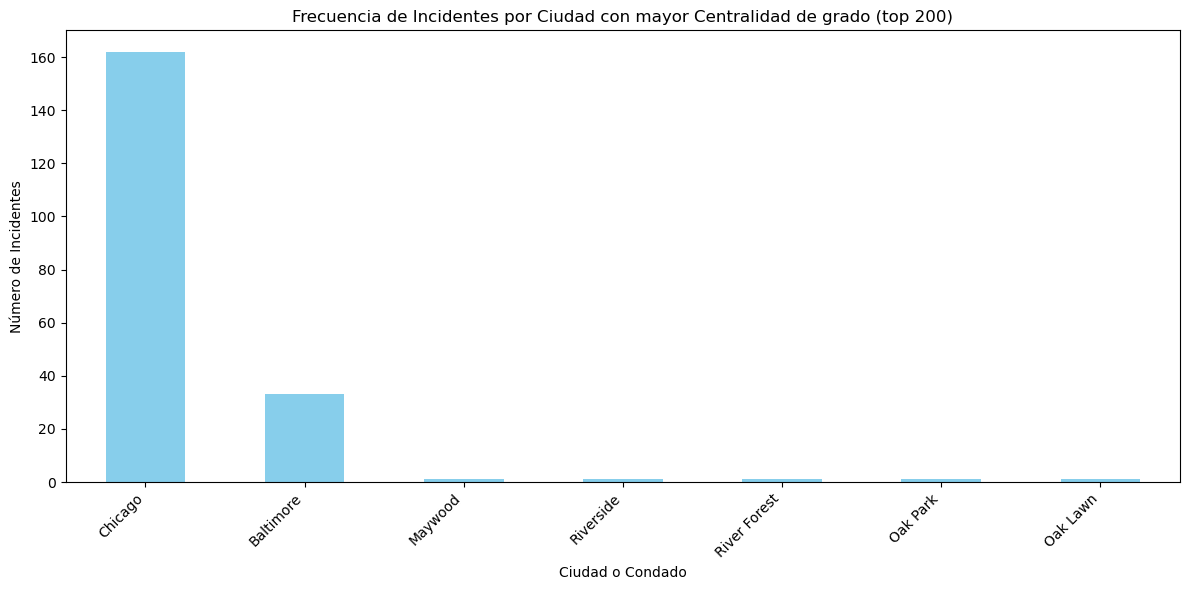

In [1310]:
df_final_filtered[df_final_filtered['incident_id'].isin(nodo_degree)]['city_or_county'].value_counts()
city_count = df_final_filtered[df_final_filtered['incident_id'].isin(nodo_degree)]['city_or_county'].value_counts()

plt.figure(figsize=(12, 6))
city_count.plot(kind='bar', color='skyblue')

# Personalizar la gráfica
plt.title('Frecuencia de Incidentes por Ciudad con mayor Centralidad de grado (top 200)')
plt.xlabel('Ciudad o Condado')
plt.ylabel('Número de Incidentes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [1268]:
# Centralidad de intermediación 
betweenness_centrality = nx.betweenness_centrality(G)

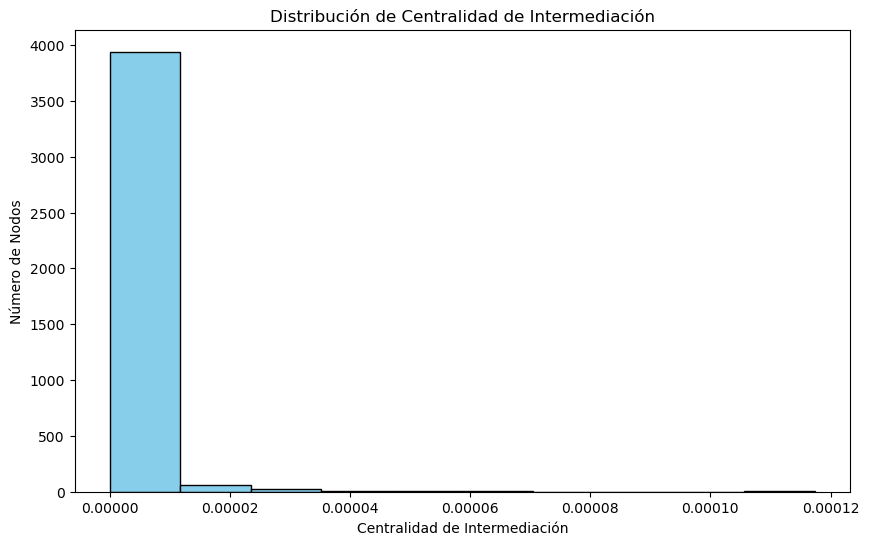

In [1290]:
import matplotlib.pyplot as plt

# Crear un histograma
plt.figure(figsize=(10, 6))
plt.hist(betweenness_centrality.values(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribución de Centralidad de Intermediación')
plt.xlabel('Centralidad de Intermediación')
plt.ylabel('Número de Nodos')
plt.show()

In [1269]:
# Centralidad de cercanía 
closeness_centrality = nx.closeness_centrality(G) 

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

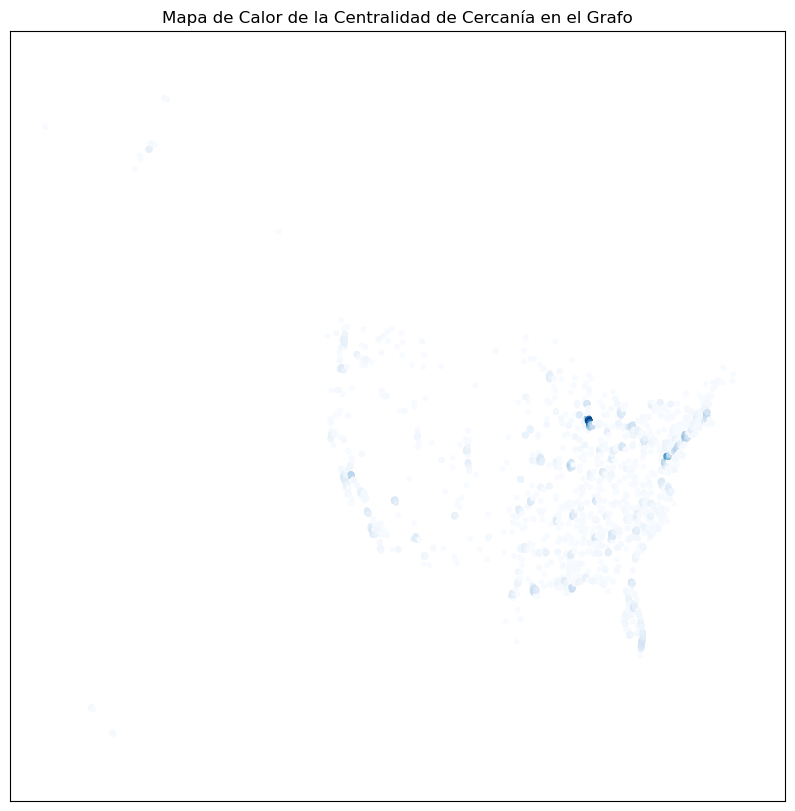

In [1296]:

# Asignar colores a los nodos según su centralidad de cercanía
node_color = [closeness_centrality[node] for node in G.nodes()]

# Dibujar el grafo con un mapa de calor
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_color,
                 node_size=10, cmap=plt.cm.Blues, edge_color='green', font_weight='bold')
plt.title('Mapa de Calor de la Centralidad de Cercanía en el Grafo')
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label='Centralidad de Cercanía')
plt.show()

In [1270]:
# Centralidad de vector propio 

eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

In [1159]:
#comunidades

In [1160]:
from networkx.algorithms.community import greedy_modularity_communities

clusters = list(greedy_modularity_communities(G))

In [1161]:
len(clusters)

869

In [1162]:
# Análisis de secuencias temporales de crímenes

In [1163]:
df_final['n_killed']

0         0
1         1
2         5
3         4
4         4
         ..
202510    0
202511    0
202512    0
202513    0
202514    0
Name: n_killed, Length: 202515, dtype: int64

In [1164]:
cluster_totals = []
for i, cluster in enumerate(clusters):
    subgraph = G.subgraph(cluster)
    total_n_killed = sum(node_data['n_killed'] for node, node_data in subgraph.nodes(data=True))
    cluster_totals.append((i + 1, total_n_killed))

# Ordenar los clústeres por el número total de fallecidos en orden descendente
sorted_clusters = sorted(cluster_totals, key=lambda x: x[1], reverse=True)

# Imprimir los clústeres ordenados por número total de fallecidos
for cluster_id, total in sorted_clusters[:10]:
    print(f'Clúster {cluster_id}: Total de fallecidos = {total}')

Clúster 1: Total de fallecidos = 47
Clúster 3: Total de fallecidos = 38
Clúster 9: Total de fallecidos = 37
Clúster 13: Total de fallecidos = 30
Clúster 24: Total de fallecidos = 28
Clúster 2: Total de fallecidos = 25
Clúster 4: Total de fallecidos = 25
Clúster 8: Total de fallecidos = 25
Clúster 6: Total de fallecidos = 23
Clúster 11: Total de fallecidos = 23


In [1165]:
!pip install cdlib

In [1169]:
from cdlib import algorithms
from cdlib import viz

In [1167]:
louvain_com = algorithms.louvain(G)

In [1172]:
print('La cantidad de comunidades es {}'.format(len(louvain_com.communities)))
# for c in louvain_com.communities:
#     print(c)

La cantidad de comunidades es 869


In [1179]:
cluster_totals = []
for i, cluster in enumerate(louvain_com.communities):
    subgraph = G.subgraph(cluster)
    total_n_killed = sum(node_data['n_killed'] for node, node_data in subgraph.nodes(data=True))
    cluster_totals.append((i + 1, total_n_killed))

# Ordenar los clústeres por el número total de fallecidos en orden descendente
sorted_clusters = sorted(cluster_totals, key=lambda x: x[1], reverse=True)

# Imprimir los clústeres ordenados por número total de fallecidos
for cluster_id, total in sorted_clusters[:10]:
    print(f'comunidades {cluster_id}: Total de fallecidos = {total}')

comunidades 1: Total de fallecidos = 47
comunidades 3: Total de fallecidos = 38
comunidades 9: Total de fallecidos = 37
comunidades 13: Total de fallecidos = 30
comunidades 24: Total de fallecidos = 28
comunidades 2: Total de fallecidos = 25
comunidades 4: Total de fallecidos = 25
comunidades 8: Total de fallecidos = 25
comunidades 6: Total de fallecidos = 23
comunidades 11: Total de fallecidos = 23


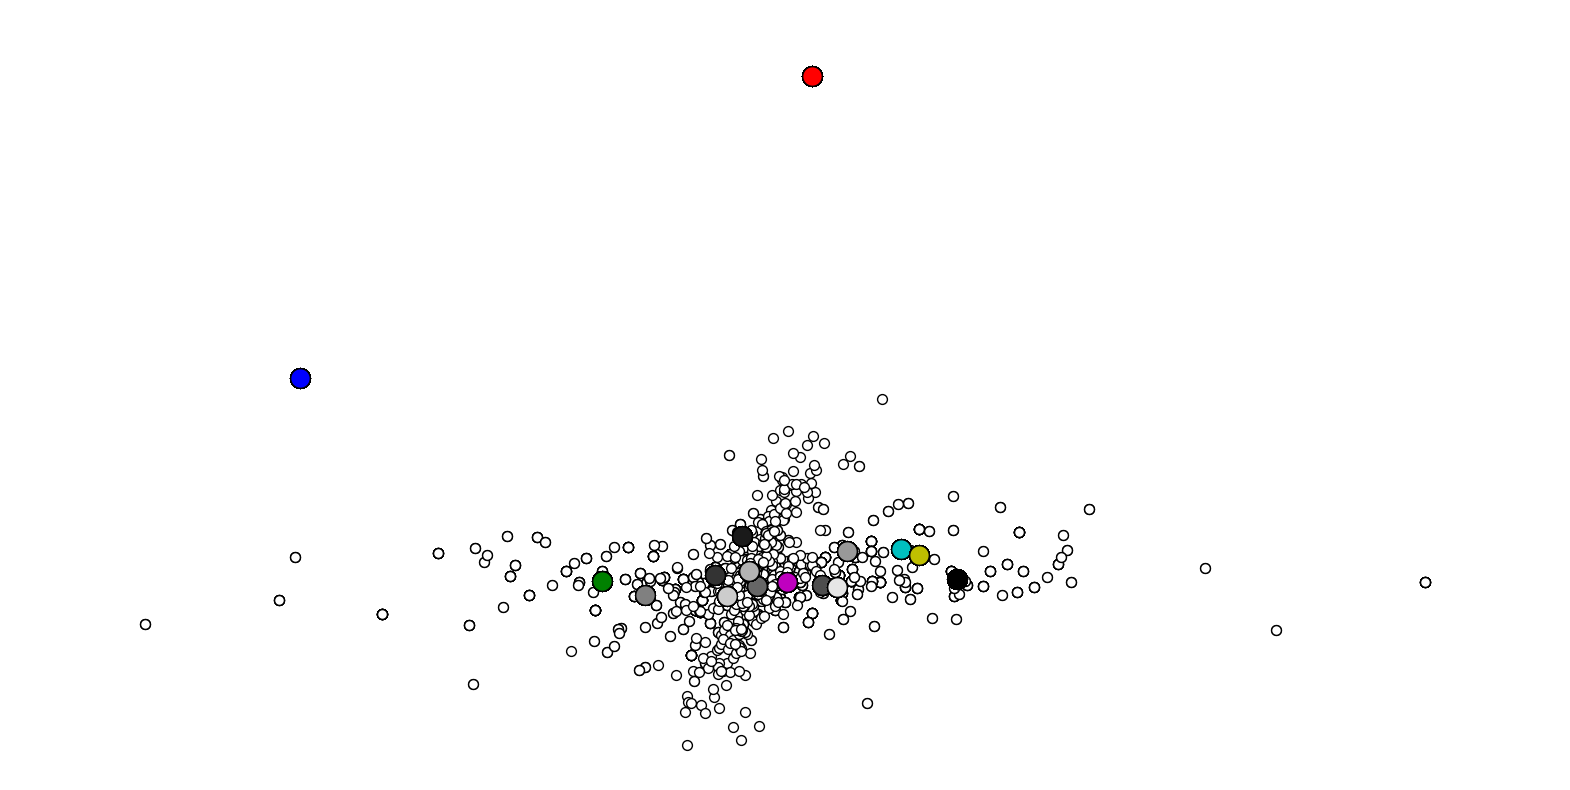

In [1170]:
#vizualizar el grafo según comunidades
pos = nx.spectral_layout(G)
viz.plot_network_clusters(G, louvain_com, pos, node_size=50, figsize=(20,10),)
plt.show()

In [1188]:
nodos_ = []
for i, cluster in enumerate(louvain_com.communities):
    if i<10:
        nodos_ =list(set(nodos_+cluster))

In [1189]:
len(nodos_)

866

In [1198]:
pos = {node: (G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes}

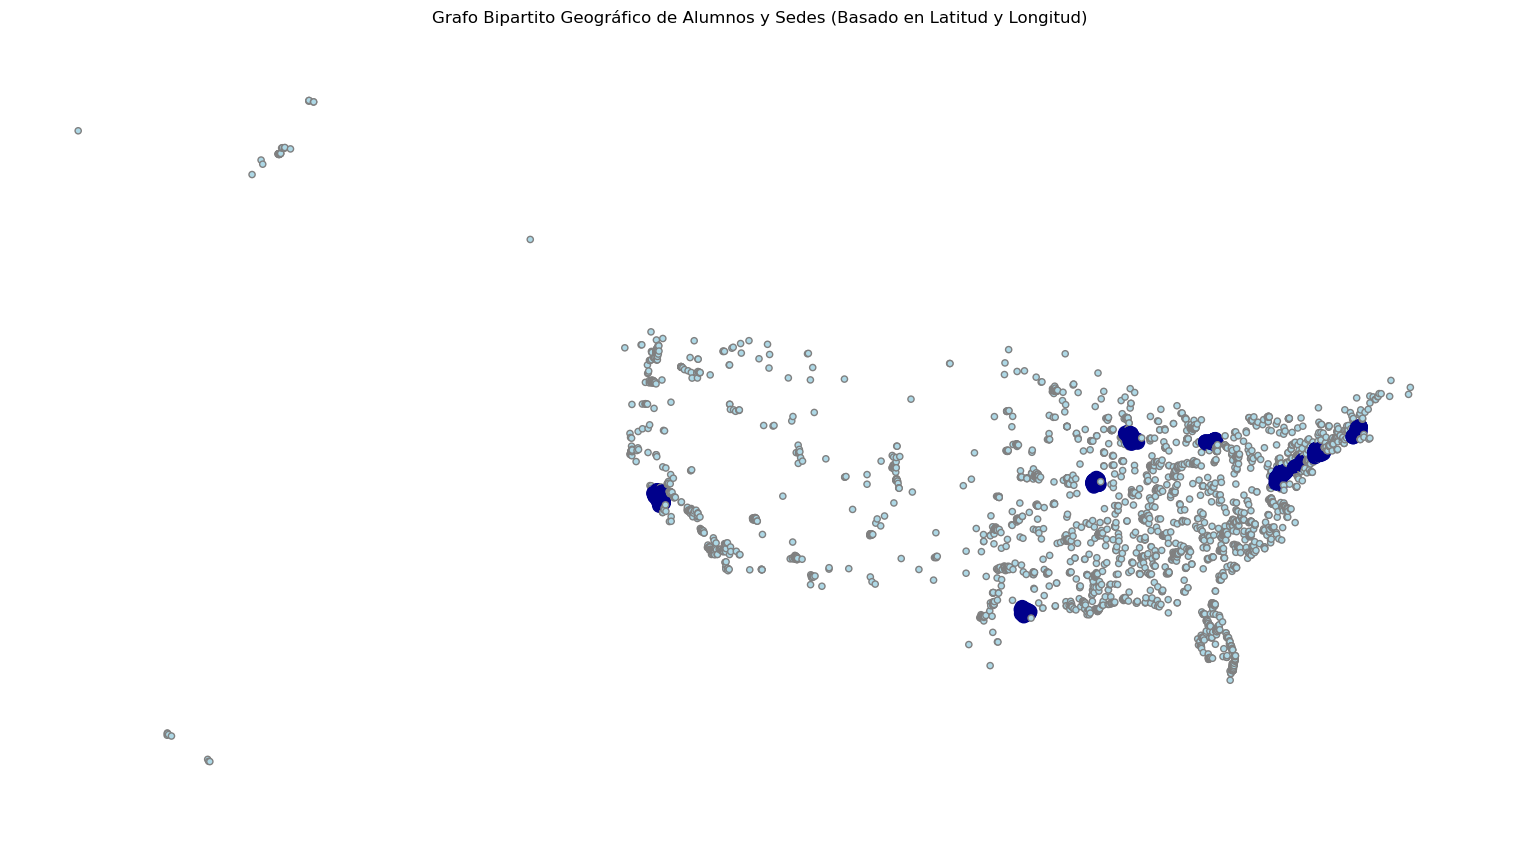

In [1217]:
# Dibujar el grafo en el espacio cartesiano basado en latitud y longitud
plt.figure(figsize=(15, 8))

# Dibujar los nodos y aristas en función de las coordenadas geográficas
nx.draw(G, pos, with_labels=False,
        node_color=['darkblue' if n in nodos_ else 'lightblue' for n in G.nodes()],
        node_size=[100 if n in nodos_ else 20 for n in G.nodes()],
        font_size=8, font_weight='bold', edge_color='gray', width=0.5, edgecolors =['darkblue' if n in nodos_ else 'gray' for n in G.nodes()])

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title("Grafo Bipartito Geográfico de Alumnos y Sedes (Basado en Latitud y Longitud)")
plt.show()